In [1]:
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import itertools
from copy import deepcopy as dcopy,copy
from skimage.morphology import label
from scipy.ndimage import measurements
import numba as nb
from IPython.display import Markdown, display,HTML,Image
from z3 import *
from math import gcd
from scipy.signal import convolve2d

### Puzzle as published 
https://www.janestreet.com/puzzles/hooks-9-index/

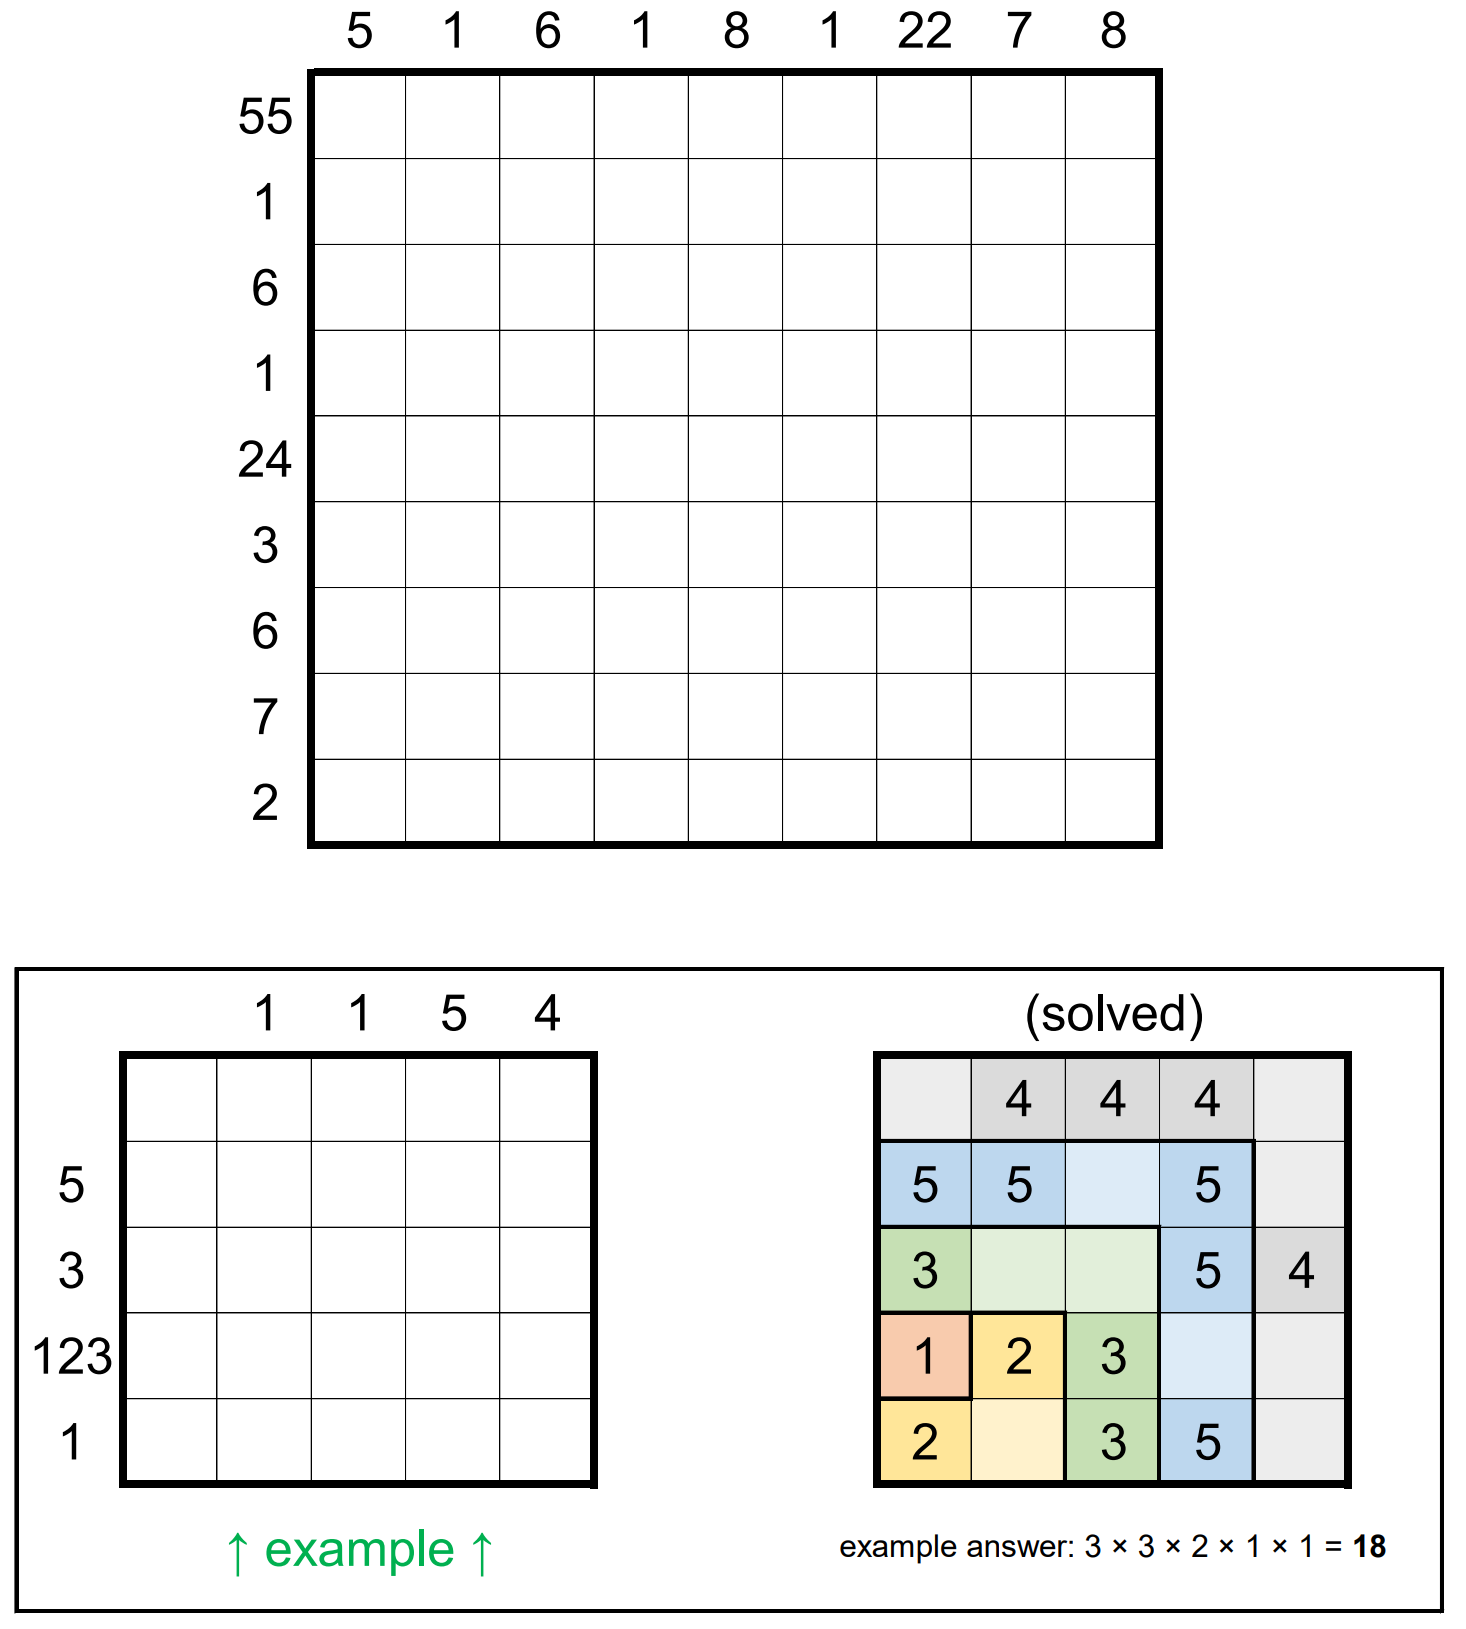

### Hooks 9

The grid above can be partitioned into 9 L-shaped “hooks”. The largest
is 9-by-9 (contains 17 squares), the next largest is 8-by-8 (contains
15 squares), and so on. The smallest hook is just a single
square. Find where the hooks are located, and place nine 9’s in one of
the hooks, eight 8’s in another, seven 7’s in another, and so on.
The filled squares must form a connected region. (Squares are
“connected” if they are orthogonally adjacent.) Furthermore, every
2-by-2 region must contain at least one unfilled square.
The numbers outside the grid denote the greatest common divisors
(GCDs) of the numbers formed by concatenating digits in consecutive
squares when reading left-to-right (within rows) or top-to-bottom
(within columns).
The answer to this puzzle is the product of the areas of the connected
groups of empty squares in the completed grid.

In [2]:
url='https://www.janestreet.com/puzzles/hooks-9-index/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
display(Markdown('### Puzzle as published \n'+url))
y =[text for text in soup.body.stripped_strings]
#display([(i,j) for i,j in enumerate(y)])
display(Image('https://www.janestreet.com/puzzles/hooks-9.png',width=400))
display(Markdown("### "+y[8]+"\n\n"+str("\n".join(y[10:14]))))

In [3]:
top = [5,1,6,1,8,1,22,7,8]
lhs = [55,1,6,1,24,3,6,7,2]
params2 = np.array([top,lhs],dtype=int)

top = [0,1,1,5,4]
lhs = [0,5,3,123,1]
params1 = np.array([top,lhs],dtype=int)



In [4]:
class Matrix():
    def __init__(self,params):
        self.gcd1 = params  
        self.N = len(params[0])
        self.potential_grids = [[-self.N,np.ones((self.N,self.N),dtype=int)*-1,[0,0,self.N,self.N],[*range(1,self.N+1)]]] 
        # list of all grids not yet ruled out.[Level,grid,coordinates of the grid yet to be filled,nums not used]
        self.solution = []
        self.start = time.time()
        self.splits =  np.array([list(i) for i in itertools.product([0, 1], repeat=self.N)],dtype=int)
        self.stop = False
        self.BLANK = np.ones((self.N,self.N),dtype=int)*-1
     
    #########################################################
    # Code to get the initial valid grids 

    def add_layer(self,grid,coords,lvl,alignment):
        row_start,col_start,row_end, col_end = coords
        if alignment == 0:
            grid[row_start:row_end,col_start] =lvl
            grid[row_start,col_start:col_end] =lvl
            new_row = row_start 
            new_col = col_start
            row_start +=1
            col_start +=1 
        elif alignment == 1:
            grid[row_start:row_end,col_start] =lvl
            grid[row_end-1,col_start:col_end] =lvl
            new_row = row_end-1
            new_col = col_start
            row_end -=1
            col_start +=1 
        elif alignment == 2:
            grid[row_start:row_end,col_end-1] =lvl
            grid[row_start,col_start:col_end] =lvl
            new_row = row_start
            new_col = col_end-1
            row_start +=1
            col_end -=1        
        else:
            grid[row_start:row_end,col_end-1] =lvl
            grid[row_end-1,col_start:col_end] =lvl
            new_row = row_end-1
            new_col = col_end-1
            row_end -=1
            col_end -=1             
        coords = [row_start,col_start,row_end, col_end]        
        return grid,coords,new_row,new_col
    
    def check_grid(self,grid,new_row,new_col,new_num):        
        #force some rows and cols to speed up
        if self.N ==9:
            if new_num ==5:
                if new_row != 0:
                    return False
                if new_col != 0:
                    return False
               
            if new_num ==8:
                if new_col != 8:
                    return False

            if new_num ==7:
                if new_row != 7:
                    return False
                if new_col != 7:
                    return False

        row = grid[new_row,:]        
        if -1 not in row:
                if self.check_line(row,self.gcd1[1][new_row]):
                    return False  
                
        col = grid[:,new_col]
        if -1 not in col:
                if self.check_line(col,self.gcd1[0][new_col]):
                    return False
        return True
            
    def check_line(self,line,param_start):
        for split in self.splits:
            test = line * split
            if self.valid_line(test,param_start):
                return False
        return True
   
    def valid_line(self,pos,param):
        if param == 0:
            return True        
        blocks = self.get_blocks(pos,param)
        if np.gcd.reduce(list(self.get_blocks(pos,param)),dtype=int) !=  param:
            return False        
        else:
            return True
    
    @staticmethod
    @nb.njit()
    def get_blocks(pos,param):
        block = 0
        inblock =0
        for p in pos:
            if p !=0:
                if inblock == 0:
                    block += p
                    inblock = 1
                else:
                    block *=10
                    block +=p                
            else:
                if inblock == 1:
                    yield block
                    block = 0
                    inblock = 0
        if inblock == 1:
            yield block
            
    #########################################################
    # Code to get the cells forced by the params
    # for each parameter loop through all the possible lines and see which are 
    # common to all the splits
    # compare the 4 different sets of forced matricies, if there are inconsistencies 
    # first value returned is zero 
    
    def forced_cells(self,hook):
        row_gcd  = np.array(self.BLANK)
        col_gcd  = np.array(self.BLANK)

        # loop through the params to determine forced cells
        for i in range(self.N):
            row_gcd[i,:] = self.forced_line(hook[i,:],self.gcd1[1][i])
            col_gcd[:,i] = self.forced_line(hook[:,i],self.gcd1[0][i])
        
        final = np.array(self.BLANK)
        
        # look at the  different versions of the  matrices and combine
        for i,j in itertools.product(range(self.N),range(self.N)):
            options = np.array([row_gcd[i,j],col_gcd[i,j]])
            if (np.any(options==1)) & (np.all(options !=0)):
                final[i,j] = 1            
            elif (np.any(options==0)) & (np.all(options !=1)):
                final[i,j] = 0
            #flag inconsistent forced matrices    
            elif (np.any(options==1)) & (np.any(options==0)):
                return False,[]
        
        # set the cell with 1 in as 1 then loop through and fill in cells neeeded to ensure connectivity 
        final[hook==1] =1
        final[label(final!=0,connectivity=1)>1] =0      
        return  True,final
      
    def forced_line(self,line,param_start):
        poss_line =[]
        for split in self.splits:
            test = line * split
            if self.valid_line(test,param_start):
                    poss_line.append(split)
        poss_array = np.array(poss_line)
        forced = np.ones(self.N,dtype=int)*-1
        for i in range(self.N):
            if np.all(poss_array[:,i]==1):
                forced[i] =1
            elif np.all(poss_array[:,i]==0):
                forced[i] =0
        return forced
        
    #########################################################
    # Fill the final cells by backtracking   
    def fill_rest(self,grid,hooks):
        for row,col in itertools.product(range(self.N),range(self.N)):
            if grid[row,col]==-1:
                for digit in range(2):
                    if self.possible(digit,row,col,grid,hooks):
                        grid[row,col] = digit
                        self.fill_rest(grid,hooks)
                        grid[row,col] = -1
                return
            
        sol_print(grid,hooks,self.gcd1)
        print("The product of the areas is : {:,.0f} in {:.2f} secs".format(self.areas(grid),time.time()-self.start))
        self.stop = True
                            
    def possible(self,digit,row,col,grid,hooks):
        test = grid*hooks
        test[row,col] = hooks[row,col]*digit

    #check the placement doesn't break connectivity
        if np.max(label(test!=0,connectivity=1)) != 1:
            return False
        
    #check the placement doesn't break 2 by 2
        if self.twobytwo(test):
            return False
    
     #check the placement doesn't exceed the permitted count of that number
        for num in range(2,self.N+1):
            if np.sum(test == num) > num:
                   return False
                
        #check rows and columns
        new_row = test[row,:]
        if np.all(new_row>-1):
            if not self.valid_line(new_row,self.gcd1[1][row]):
                return False  
            
        new_col = test[:,col]    
        if np.all(new_col>-1):
            if not self.valid_line(new_col,self.gcd1[0][col]):
                return False

        # final checks if the placement completes the grid    
        if np.all(test > -1):
        #check counts again
            for i in range(2,self.N+1):
                if np.sum(test == i) != i:
                    return False      
        return True

    def twobytwo(self,grid):
        return np.any(convolve2d(grid > 0, np.ones((2, 2)), mode='valid') == 4)
    
    ##############################################
    # Get the products of the areas of the connected cells    
    def areas(self,grid):
        labels, num = measurements.label(np.logical_not(grid!=0))
        areas = measurements.sum(np.logical_not(grid>=1), labels, index=range(1, num+1))
        return np.prod(areas)

    ###############################################
    # Main solver.    
    def solve(self):
        while len(self.potential_grids) > 0:
            temp_grid = self.potential_grids.pop(0)
            #create the potential rotations at the given level
            rotations = []
            l,g,c,nums = temp_grid
            invalid =0
            for num in nums:
                if num > -l*2:
                    invalid =1
                    
            if invalid ==0:
                for num in nums:
                    for alignment in range(4):
                        lvl= np.array(l)
                        grid= np.array(g)
                        coords=np.array(c)
                        if lvl != -1 and num > 1:                            
                            grid,coords,new_row,new_col = self.add_layer(grid,coords,num,alignment)
                            rotations.append([lvl+1,grid,coords,[n for n in nums if n != num ],new_row,new_col,num])
                        else:
                            grid,coords,new_row,new_col = self.add_layer(grid,coords,num,alignment)
                            rotations = [[lvl+1,grid,coords,[],new_row,new_col,num]]

                #check valid grids (where the sum can be made from available digits) and save the ones that work
                for i in range(len(rotations)):
                    lvl,g,coords,nums,new_row,new_col,new_num = rotations[i]
                    if self.check_grid(g,new_row,new_col,new_num):
                        if lvl !=0:    
                            self.potential_grids.append([lvl,g,coords,nums])
                        else:
                            self.solution.append(g)                             
                      
        print("There are {} valid hook placements.Took {:.2f} secs".format(len(self.solution),time.time()-self.start))
        #solve each grid in the cut down list
        forced_grids = []
        for hooks in self.solution:
            if self.stop == False:        
                flag,forced_grid = self.forced_cells(hooks)
                if flag:
                    #for valid forced grids solve the final matrix
                    #print(i," still to solve",np.sum(forced_grid==-1))
                    self.fill_rest(forced_grid,hooks)
                
#########################
# Code to print in a "nice" format
                            
def sol_print(solved,matrix,gcd1):
    fig,ax = plt.subplots(1,1,figsize=(4,4))
    x = np.array((solved*matrix).astype('int').astype('str'))
    x[x=="0"] ="-"
    ax = sns.heatmap(matrix,annot=x,cbar=False,cmap="tab10",fmt="",linewidths=0.25,
                    xticklabels=gcd1[0], yticklabels=gcd1[1], annot_kws={"fontsize":12})
    ax.tick_params(left=False, bottom=False,labelleft=True, labelright=False,labeltop=True,labelbottom=False)
    plt.xticks(rotation=0,fontsize =14)
    plt.yticks(rotation=0,fontsize =14)
    plt.tight_layout()
    plt.show()
    

There are 19 valid hook placements.Took 0.93 secs


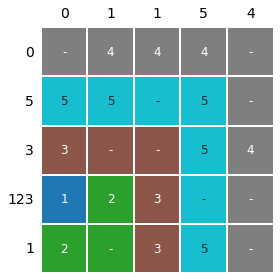

The product of the areas is : 18 in 1.37 secs


In [5]:
test = Matrix(params1)
test.solve()

There are 717 valid hook placements.Took 63.98 secs


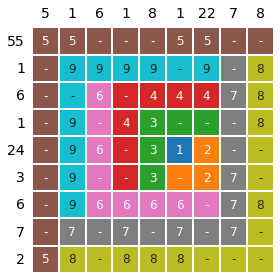

The product of the areas is : 15,552 in 299.42 secs


In [6]:
test = Matrix(params2)
test.solve()